In [166]:
from PIL import Image, ImageEnhance
import cv2,os
import numpy, time, glob
from matplotlib import pyplot as plt
%matplotlib inline
path = "D:\\Nick\\imag\\dual_link\\"
originalpath = path+'original\\'
testpath = path+'test\\'
predpath = path+'preds\\'
for i in range(len(os.listdir(originalpath))):
    print(originalpath+'{}.jpg'.format(i+1))
    image = cv2.imread(originalpath+'{}.jpg'.format(i+1))
    image = cv2.resize(image, (128, 128),cv2.INTER_AREA)
    cv2.imwrite(testpath + str(i+1) + '.png', image)

D:\Nick\imag\dual_link\original\1.jpg
D:\Nick\imag\dual_link\original\2.jpg
D:\Nick\imag\dual_link\original\3.jpg
D:\Nick\imag\dual_link\original\4.jpg
D:\Nick\imag\dual_link\original\5.jpg
D:\Nick\imag\dual_link\original\6.jpg


In [169]:
from __future__ import division, print_function, absolute_import
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
import PIL
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt
# Training Parameters
learning_rate = 0.0001
num_steps = 100
batch_size = 128

# Network Parameters
num_input = 16384 # MNIST data input (img shape: 128*128)
num_classes = 6 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

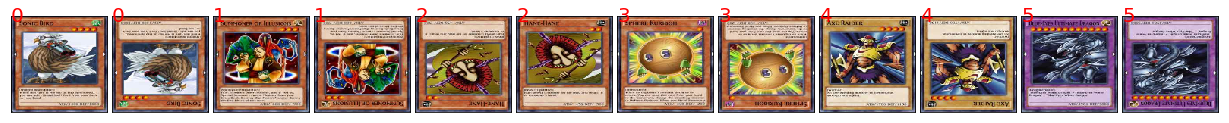

In [207]:
import os
digits = []
labels = []
fig = plt.figure(figsize=(28,28))
cnt = 0
dis = 0
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for img in os.listdir(testpath):
    #if cnt == 300:break
    pil_image = PIL.Image.open(testpath+'{}'.format(img))
    
    ax = fig.add_subplot(10, 20, cnt+1, xticks=[], yticks=[])
    ax.imshow(pil_image,interpolation='nearest')
    ax.text(0, 7, str(dis), color='red', fontsize = 20)

    digits.append([pixel for pixel in iter(pil_image.getdata())])
    labels.append(dis)
    cnt = cnt + 1
    if not cnt%2:
        dis+=1

In [209]:
train_images = numpy.array(digits, dtype='float32')
train_labels = numpy.array(labels, dtype='int32')

In [210]:
print(tf.cast(train_labels, dtype=tf.string))

Tensor("Cast_7:0", shape=(12,), dtype=string)


In [211]:
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 128, 128, 3])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)
        
        conv3 = tf.layers.conv2d(conv2, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv3 = tf.layers.max_pooling2d(conv3, 2, 2)
        
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv3)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [212]:
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [213]:
model = tf.estimator.Estimator(model_fn)

# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': train_images}, y=train_labels,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_model_dir': 'C:\\Users\\nick\\AppData\\Local\\Temp\\tmpvjjjgzma', '_save_checkpoints_steps': None, '_tf_random_seed': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\nick\AppData\Local\Temp\tmpvjjjgzma\model.ckpt.
INFO:tensorflow:step = 1, loss = 143.676
INFO:tensorflow:Saving checkpoints for 97 into C:\Users\nick\AppData\Local\Temp\tmpvjjjgzma\model.ckpt.
INFO:tensorflow:Saving checkpoints for 100 into C:\Users\nick\AppData\Local\Temp\tmpvjjjgzma\model.ckpt.
INFO:tensorflow:Loss for final step: 0.0.


In [214]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': train_images}, y=train_labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-27-09:33:25
INFO:tensorflow:Restoring parameters from C:\Users\nick\AppData\Local\Temp\tmpvjjjgzma\model.ckpt-100
INFO:tensorflow:Finished evaluation at 2017-12-27-09:33:26
INFO:tensorflow:Saving dict for global step 100: accuracy = 1.0, global_step = 100, loss = 0.0


In [155]:
for i, img in enumerate(os.listdir(predpath)):
    image = image=cv2.imread(predpath+'{}'.format(img))
    image = cv2.resize(image, (128, 128),cv2.INTER_AREA)
    if 'jpg' in img:
        cv2.imwrite(predpath + str(i+1) + '.png', image)

In [156]:
def getpredimg():
    dig = []
    for img in os.listdir(predpath):
        if 'jpg' in img:continue
        image = PIL.Image.open(predpath+'{}'.format(img))
        print(img)
        if 'jpg' not in img:
            dig.append([pixel for pixel in iter(image.getdata())])
    return dig

In [161]:
digs = getpredimg()
t_images = numpy.array(digs, dtype='float32')

1.png
3.png
5a.png


INFO:tensorflow:Restoring parameters from C:\Users\nick\AppData\Local\Temp\tmp_urzq47z\model.ckpt-100


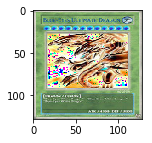

Model prediction: 青眼究極龍


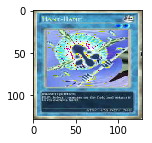

Model prediction: 嘎嘎


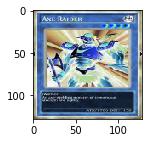

Model prediction: 斧戰士


In [162]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': t_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
result = ['音速鳥','召喚師','嘎嘎','例子球','斧戰士','青眼究極龍']
# Display

for i in range(len(t_images)):
    plt.figure(figsize=(2,2))
    plt.imshow(numpy.reshape(t_images[i], [128, 128,3]))
    plt.show()
    print("Model prediction:", result[preds[i]])